# Kaggle - Titanic

In [413]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

%matplotlib inline  

In [414]:
# List files
os.listdir("../dados/")

['all.zip', 'gender_submission.csv', 'test.csv', 'train.csv']

In [415]:
# Read data
train_df = pd.read_csv('../dados/train.csv')
test_df = pd.read_csv('../dados/test.csv')

In [416]:
test_df.shape

(418, 11)

In [417]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data information

1. Age ==>> Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

2. Sibsp ==>> The dataset defines family relations in this way...

   a. Sibling = brother, sister, stepbrother, stepsister

   b. Spouse = husband, wife (mistresses and fiancés were ignored)

3. Parch ==>> The dataset defines family relations in this way...

   a. Parent = mother, father

   b. Child = daughter, son, stepdaughter, stepson

   c. Some children travelled only with a nanny, therefore parch=0 for them.

4. Pclass ==>> A proxy for socio-economic status (SES)

   1st = Upper
   2nd = Middle
   3rd = Lower
5. Embarked ==>> nominal datatype
6. Name ==>> nominal datatype . It could be used in feature engineering to derive the gender from title
7. Sex ==>> nominal datatype
8. Ticket ==>> that have no impact on the outcome variable. Thus, they will be excluded from analysis
9. Cabin ==>> is a nominal datatype that can be used in feature engineering
10. Fare ==>> Indicating the fare
11. PassengerID ==>> have no impact on the outcome variable. Thus, it will be excluded from analysis
12. Survival is ==>> dependent variable , 0 or 1

In [418]:
#Data information

print("Shape: " + str(train_df.shape))
print("Size: " + str(train_df.size))

Shape: (891, 12)
Size: 10692


In [419]:
#Count NA values on each column
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [420]:
#Info about dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [421]:
# Class information
train_df["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [422]:
test_df.groupby('Pclass').count()

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,
1,107,107,107,98,107,107,107,107,80,107
2,93,93,93,88,93,93,93,93,7,93
3,218,218,218,146,218,218,218,217,4,218


Text(0.5,1,'Total by gender')

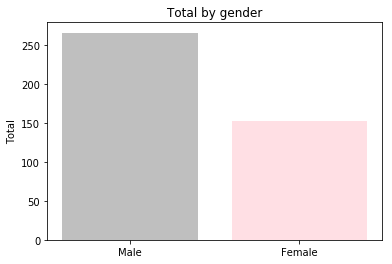

In [423]:
male = len(test_df.loc[test_df['Sex'] == 'male'])
female = len(test_df.loc[test_df['Sex'] == 'female'])

objects = ('Male', 'Female')
y_pos = np.arange(len(objects))
data = [male, female]

plt.bar(y_pos, data, align='center', alpha=0.5, color=["gray", "pink"])
plt.xticks(y_pos, objects)
plt.ylabel('Total')
plt.title('Total by gender')

## Encoding

In [424]:
# Get average of age
#total = train_df['Age'].mean()

In [425]:
# Replace nan ages value with average
#train_df['Age'] = train_df['Age'].fillna(total)

In [426]:
#train_df["Fare"].isnull().sum()

In [427]:
#train_df["Fare"] = train_df["Fare"].fillna(train_df["Fare"].median())

In [428]:
#train_df["Embarked"].isnull().sum()

In [429]:
#train_df["Embarked"] = train_df["Embarked"].fillna("S")

In [430]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

train_df = transform_features(train_df)
test_df = transform_features(test_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [431]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,male,Young Adult,0,0,1_quartile,N,"Kelly,",Mr.
1,893,3,female,Adult,1,0,1_quartile,N,"Wilkes,",Mrs.
2,894,2,male,Senior,0,0,2_quartile,N,"Myles,",Mr.
3,895,3,male,Young Adult,0,0,2_quartile,N,"Wirz,",Mr.
4,896,3,female,Student,1,1,2_quartile,N,"Hirvonen,",Mrs.


In [432]:
def encode_features(train_df, test_df):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([train_df[features], test_df[features]])
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df_combined[feature])
        train_df[feature] = le.transform(train_df[feature])
        test_df[feature] = le.transform(test_df[feature])
    return train_df, test_df

In [433]:
train_df, test_df = encode_features(train_df, test_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [434]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


In [462]:
x_all = train_df.drop(['Survived', 'PassengerId'], axis=1)
y_all = train_df['Survived']

num_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=num_test, random_state=100)

## RANDOM FOREST

In [463]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
rfc = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rfc = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)

rfc_prediction = rfc.predict(X_test)
rfc_score=accuracy_score(y_test, rfc_prediction)
print(rfc_score)


0.8379888268156425


## XGBoost

In [464]:
from xgboost import XGBClassifier
import xgboost
xgboost = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
xgb_prediction = xgboost.predict(X_test)
xgb_score= accuracy_score(y_test, xgb_prediction)
print(xgb_score)

C:\Users\roliveiraa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8156424581005587


## Logistic Regression

In [465]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#Prediction
logreg_prediction = logreg.predict(X_test)
logreg_score=accuracy_score(y_test, logreg_prediction)
print(logreg_score)

0.7877094972067039


# SVM

In [468]:
from sklearn import svm

#Create list of c values to try
c_vals = list(range(1, 100))

#Accuracy list
accuracy = [0 for i in range(99)]

for i, c in enumerate(c_vals):
    clf = svm.SVC(C=c, gamma=0.003, decision_function_shape='ovo')
    clf.fit(X_train, y_train)

    svm_prediction = clf.predict(X_test)
    accuracy[i] = accuracy_score(y_test, svm_prediction)

print("Best C Value:", c_vals[accuracy.index(max(accuracy))])
print("Prediction Accuracy: ", max(accuracy))

clf = svm.LinearSVC(C=max(accuracy))
clf.fit(X_train, y_train)

Best C Value: 83
Prediction Accuracy:  0.7597765363128491


LinearSVC(C=0.7597765363128491, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

## KNN

In [467]:
from sklearn.neighbors import KNeighborsClassifier

#Create list of c values to try
ks = [i + 1 for i in range(20)]

#Accuracy list
accuracy = [0 for i in range(20)]

#Loop through c_values
for i, k in enumerate(ks):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) 

    knn_predict = neigh.predict(X_test)
    accuracy[i] = accuracy_score(y_test, knn_predict)
    
print("Best k Value:", ks[accuracy.index(max(accuracy))])
print("Prediction Accuracy: ", max(accuracy))

neigh = KNeighborsClassifier(n_neighbors=max(accuracy))
neigh.fit(X_train, y_train)

Best k Value: 1
Prediction Accuracy:  0.6424581005586593


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=0.6424581005586593,
           p=2, weights='uniform')

## Submission

In [444]:
result = xgboost.predict(test_df.drop(['PassengerId'], axis=1))

C:\Users\roliveiraa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [445]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": result
    })
submission.to_csv('titanic.csv', index=False)

In [443]:
submission.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,0
9,901,0
